In [5]:
# In Class Lab 7 Template

# G. Besla
# with code from R. Hoffman and E. Patel

# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile


# This Project:

A) Visualizing the different encounters between MW and M31 to visualize and quantifay mass transfer between the two galaxies (disk matter, bulge matter, and dark matter)

B) Using visual particle identification to mark mass transfer sequentially

C) Comparing gravitational potential energies and kinetic energies of particles to see which ones are bound to a galaxy, or escaping both entirely

In [6]:
# Code for plotting contours
#from https://gist.github.com/adrn/3993992

import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    
    # You might need to add a few levels
    sub_sigma1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.75))
    sub_sigma2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    sub_sigma3 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.90))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, sub_sigma1, sub_sigma2, sub_sigma3, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.75', '0.80', '0.90','0.95', '0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

Use the CenterOfMass code to compute the positions and velocities of all particles in M31's disk relative to its center of mass position and motion.

In [2]:
'''
To visualize which snapnumbers are important for investigating mass transfer, we need to first visualize the mergers
This can be done by plotting the density contours of M31 and M33 on the same plot, looping through different snapnumbers to see when they merge
We already know times to start at since we plotted the COM galaxy separations over time in HW6.
HW 6 predicts the first close encounter to occur at ~4Gyr, and the second to occur at ~5.6-5.8 Gyr. Merger 3 marks when the galaxies merge together, at which point
#mass transfer will be difficult to calculate. 
'''
#let's start with disk particles, then try bulge particles and dark matter later
#let's also start at time 0 to get the code working

'\nTo visualize which snapnumbers are important for investigating mass transfer, we need to first visualize the mergers\nThis can be done by plotting the density contours of M31 and M33 on the same plot, looping through different snapnumbers to see when they merge\nWe already know times to start at since we plotted the COM galaxy separations over time in HW6.\nHW 6 predicts the first close encounter to occur at ~4Gyr, and the second to occur at ~5.6-5.8 Gyr. Merger 3 marks when the galaxies merge together, at which point\n#mass transfer will be difficult to calculate. \n'

In [11]:
# Compute COM of M31 using disk particles
COMD_M31 = CenterOfMass("M31_000.txt",2)
COMP_M31 = COMD_M31.COM_P(0.1)
COMV_M31 = COMD_M31.COM_V(COMP_M31[0],COMP_M31[1],COMP_M31[2])
# Determine positions of disk particles relative to COM 
xD_M31 = COMD_M31.x - COMP_M31[0].value 
yD_M31 = COMD_M31.y - COMP_M31[1].value 
zD_M31 = COMD_M31.z - COMP_M31[2].value 

# total magnitude
rtot = np.sqrt(xD_M31**2 + yD_M31**2 + zD_M31**2)

# Determine velocities of disk particles relatiev to COM motion
vxD_M31 = COMD_M31.vx - COMV_M31[0].value 
vyD_M31 = COMD_M31.vy - COMV_M31[1].value 
vzD_M31 = COMD_M31.vz - COMV_M31[2].value 

# total velocity 
vtot_M31 = np.sqrt(vxD_M31**2 + vyD_M31**2 + vzD_M31**2)

# Vectors for r and v 
r_M31 = np.array([xD_M31,yD_M31,zD_M31]).T # transposed 
v_M31 = np.array([vxD_M31,vyD_M31,vzD_M31]).T

In [14]:
# Compute COM of MW using disk particles
COMD_MW = CenterOfMass("MW_000.txt",2)
COMP_MW = COMD_MW.COM_P(0.1)
COMV_MW = COMD_MW.COM_V(COMP_MW[0],COMP_MW[1],COMP_MW[2])
# Determine positions of disk particles relative to COM 
xD_MW = COMD_MW.x - COMP_MW[0].value 
yD_MW = COMD_MW.y - COMP_MW[1].value 
zD_MW = COMD_MW.z - COMP_MW[2].value 

# total magnitude
rtot_MW = np.sqrt(xD_MW**2 + yD_MW**2 + zD_MW**2)

# Determine velocities of disk particles relatiev to COM motion
vxD_MW = COMD_MW.vx - COMV_MW[0].value 
vyD_MW = COMD_MW.vy - COMV_MW[1].value 
vzD_MW = COMD_MW.vz - COMV_MW[2].value 

# total velocity 
vtot_MW = np.sqrt(vxD_MW**2 + vyD_MW**2 + vzD_MW**2)

# Vectors for r and v 
r_MW = np.array([xD_MW,yD_MW,zD_MW]).T # transposed 
v_MW = np.array([vxD_MW,vyD_MW,vzD_MW]).T

# Part 1:

Create 2d density histogram of M31 and MW on the same plot, so we must undo the COM centering

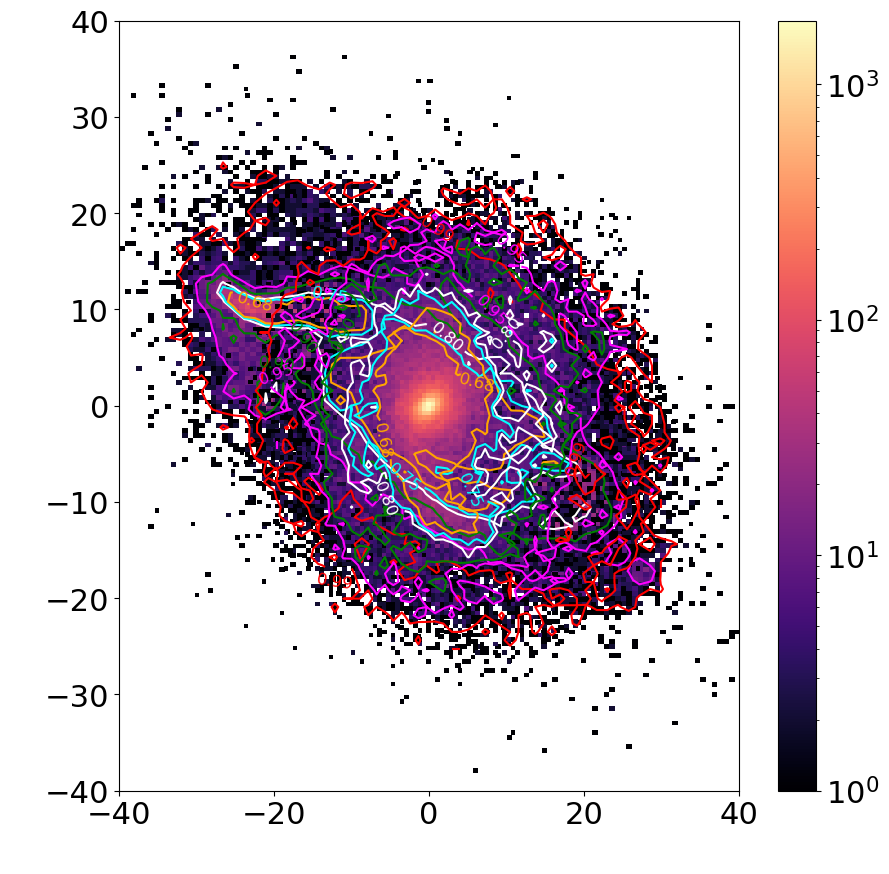

In [15]:
# 1) Make plots 

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(10, 10))

# ADD HERE
# plot the particle density for M31 using a 2D historgram
#plt.hist2d(pos1,pos2, bins=10, norm=LogNorm(), cmap= 'magma')
# cmap options: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html  
#   e.g. magma, viridis
# can modify bin number to make the plot smoother


plt.hist2d(xD_M31,yD_M31, bins=150, norm=LogNorm(), cmap= 'magma')
plt.hist2d(xD_MW,yD_MW, bins=150, norm=LogNorm(), cmap= 'magma')
plt.colorbar()

# ADD HERE
# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# remember to adjust this if there are other contours added
# density_contour(pos1, pos2, res1, res2, ax=ax, colors=[])


density_contour(xD_M31, yD_M31, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
density_contour(xD_MW, yD_MW, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
# Add axis labels
plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save to a file
plt.savefig('Lab7_M31Disk.png')

Let's try not centering the plot on the center of mass of either of the galaxies, but instead their locations in space given by their x and y coordinates,
i.e let's remove - [0].value from everything so that they are not stacked on top of each other

In [43]:

def visualize_galaxy(filename):
    '''
    find the x, y, and z posistions of each galaxy's disk matter in order to plot it on a 2d histogram alongside another galaxy
    inputs:
        filename: str
            the filename of the galaxy we wish to visualize
    outputs: 
        xD, yD, zD: 3 numpy arrays
            the x positions, y positions, and z positions of the galaxy of interest
    '''
    COMD = CenterOfMass(filename,2)
    xD = COMD.x #x position list
    yD = COMD.y #y position list
    zD = COMD.z #z position list
    '''
    #do not need these other values for now
    # total magnitude
    rtot = np.sqrt(xD_M31**2 + yD_M31**2 + zD_M31**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD_M31 = COMD_M31.vx
    vyD_M31 = COMD_M31.vy 
    vzD_M31 = COMD_M31.vz 

    # total velocity 
    vtot_M31 = np.sqrt(vxD_M31**2 + vyD_M31**2 + vzD_M31**2)

    # Vectors for r and v 
    r_M31 = np.array([xD_M31,yD_M31,zD_M31]).T # transposed 
    v_M31 = np.array([vxD_M31,vyD_M31,vzD_M31]).T
    '''
    return xD, yD, zD

In [17]:
# Compute COM of MW using disk particles
COMD_MW = CenterOfMass("MW_000.txt",2)
COMP_MW = COMD_MW.COM_P(0.1)
COMV_MW = COMD_MW.COM_V(COMP_MW[0],COMP_MW[1],COMP_MW[2])
# Determine positions of disk particles relative to COM 
xD_MW = COMD_MW.x 
yD_MW = COMD_MW.y  
zD_MW = COMD_MW.z 

# total magnitude
rtot_MW = np.sqrt(xD_MW**2 + yD_MW**2 + zD_MW**2)

# Determine velocities of disk particles relatiev to COM motion
vxD_MW = COMD_MW.vx 
vyD_MW = COMD_MW.vy 
vzD_MW = COMD_MW.vz 

# total velocity 
vtot_MW = np.sqrt(vxD_MW**2 + vyD_MW**2 + vzD_MW**2)

# Vectors for r and v 
r_MW = np.array([xD_MW,yD_MW,zD_MW]).T # transposed 
v_MW = np.array([vxD_MW,vyD_MW,vzD_MW]).T

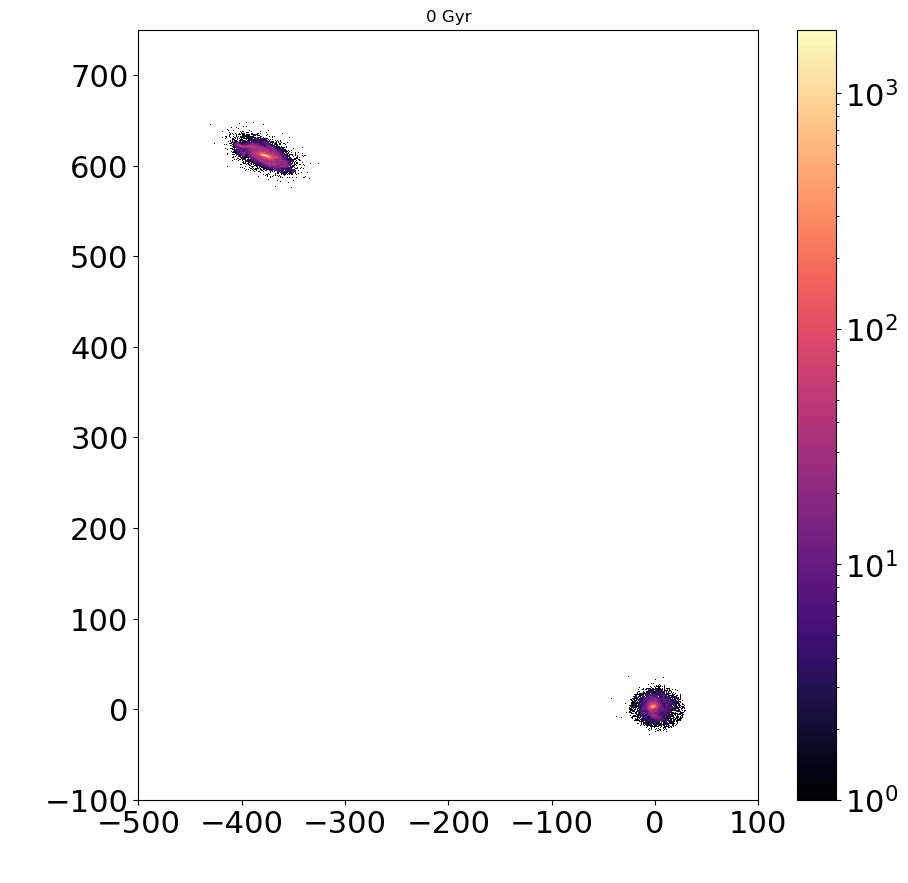

In [47]:
# M31 Disk Density 
fig, ax= plt.subplots(figsize=(10, 10))

# ADD HERE
# plot the particle density for M31 using a 2D historgram
#plt.hist2d(pos1,pos2, bins=10, norm=LogNorm(), cmap= 'magma')
# cmap options: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html  
#   e.g. magma, viridis
# can modify bin number to make the plot smoother

xD_M31, yD_M31, zD_M31 = visualize_galaxy('M31_000.txt')
xD_MW, yD_MW, zD_MW = visualize_galaxy('MW_000.txt')
plt.hist2d(xD_M31,yD_M31, bins=150, norm=LogNorm(), cmap= 'magma')
plt.hist2d(xD_MW,yD_MW, bins=150, norm=LogNorm(), cmap= 'magma')
plt.colorbar()

# ADD HERE
# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# remember to adjust this if there are other contours added
# density_contour(pos1, pos2, res1, res2, ax=ax, colors=[])


#density_contour(xD_M31, yD_M31, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
#density_contour(xD_MW, yD_MW, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
# Add axis labels
plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)
plt.title('0 Gyr')

#set axis limits
plt.ylim(-100,750) #custom fit to get both galaxies in frame at once
plt.xlim(-500,100) #custom fit to get both galaxies in frame at once

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save to a file
plt.savefig('Lab7_M31Disk.png')

# Okay, now we have two galaxies on the same plot. Let's find a snapnumber where they are closer together and redo this plot...

snapnumber 270 = 3.8 Gyr, 
snapnumber 285 = 4.0 Gyr
snapnumber 300 = 4.2 Gyr

let's try these two snapnumbers

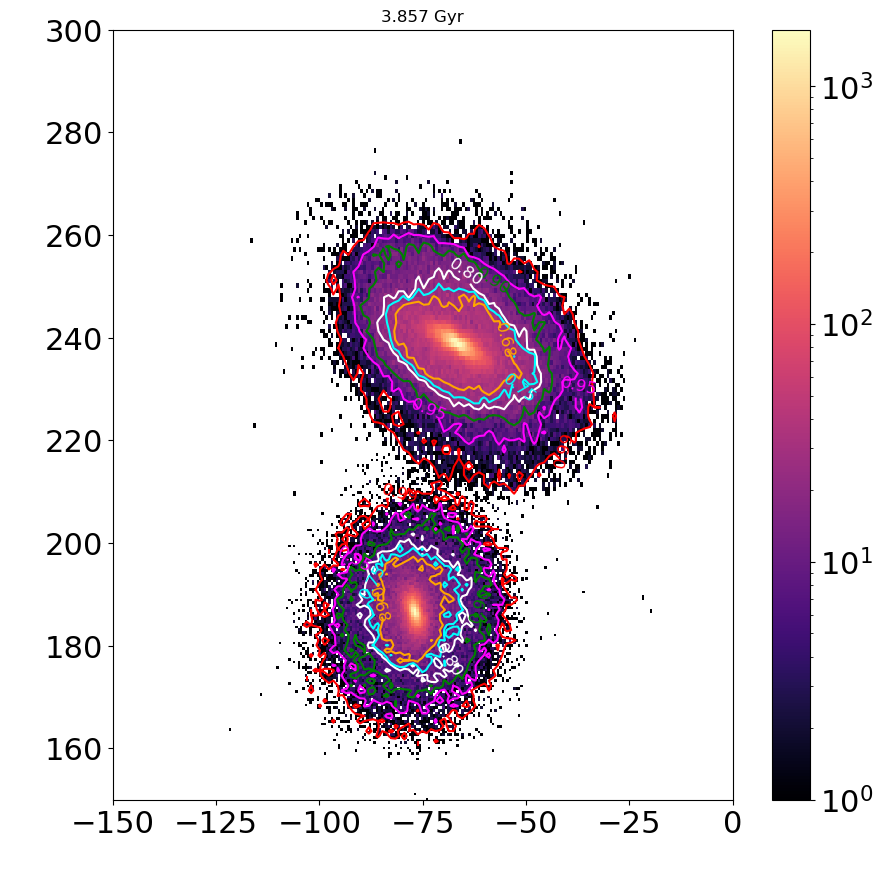

In [48]:
xD_M31, yD_M31, zD_M31 = visualize_galaxy('M31_270.txt')
xD_MW, yD_MW, zD_MW = visualize_galaxy('MW_270.txt')

fig, ax= plt.subplots(figsize=(10, 10))

plt.hist2d(xD_M31,yD_M31, bins=150, norm=LogNorm(), cmap= 'magma')
plt.hist2d(xD_MW,yD_MW, bins=150, norm=LogNorm(), cmap= 'magma')
plt.colorbar()

density_contour(xD_M31, yD_M31, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
density_contour(xD_MW, yD_MW, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])

plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)
plt.title('3.857 Gyr')

#set axis limits
plt.ylim(150,300)
plt.xlim(-150,0)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size





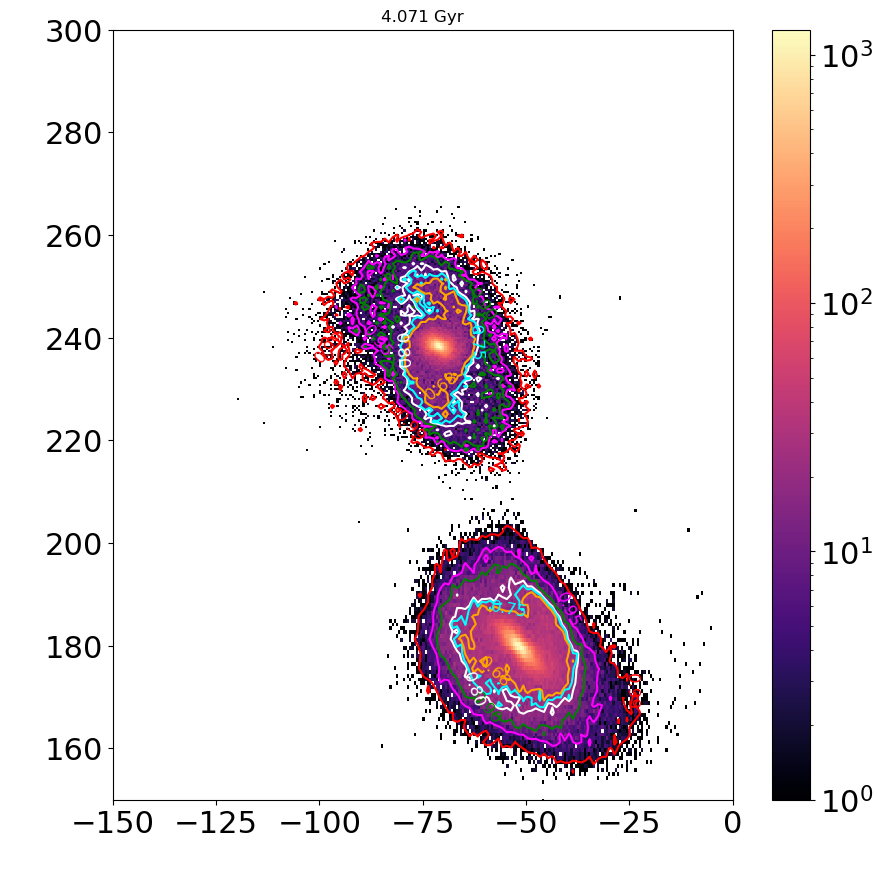

In [49]:
xD_M31, yD_M31, zD_M31 = visualize_galaxy('M31_285.txt')
xD_MW, yD_MW, zD_MW = visualize_galaxy('MW_285.txt')

fig, ax= plt.subplots(figsize=(10, 10))

plt.hist2d(xD_M31,yD_M31, bins=150, norm=LogNorm(), cmap= 'magma')
plt.hist2d(xD_MW,yD_MW, bins=150, norm=LogNorm(), cmap= 'magma')
plt.colorbar()

density_contour(xD_M31, yD_M31, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
density_contour(xD_MW, yD_MW, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])

plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)
plt.title('4.071 Gyr')

#set axis limits
plt.ylim(150,300)
plt.xlim(-150,0)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

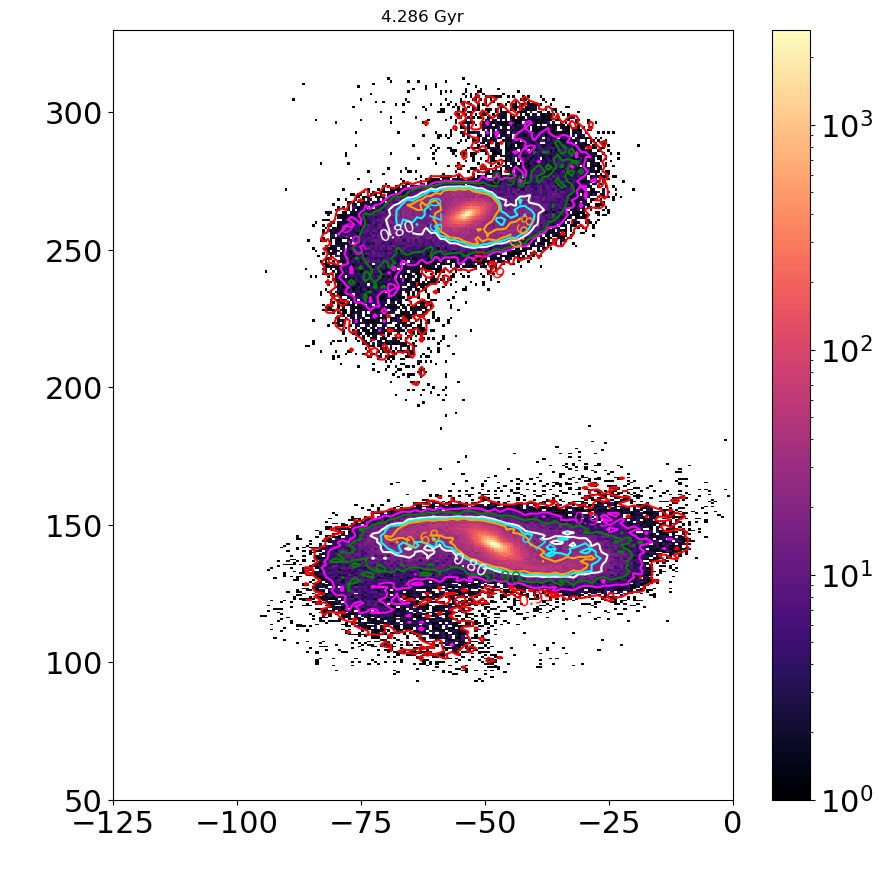

In [50]:
xD_M31, yD_M31, zD_M31 = visualize_galaxy('M31_300.txt')
xD_MW, yD_MW, zD_MW = visualize_galaxy('MW_300.txt')

fig, ax= plt.subplots(figsize=(10, 10))

plt.hist2d(xD_M31,yD_M31, bins=150, norm=LogNorm(), cmap= 'magma')
plt.hist2d(xD_MW,yD_MW, bins=150, norm=LogNorm(), cmap= 'magma')
plt.colorbar()

density_contour(xD_M31, yD_M31, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])
density_contour(xD_MW, yD_MW, 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])

plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)
plt.title('4.286 Gyr')

#set axis limits
plt.ylim(50,330)
plt.xlim(-125,0)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

At least for the first encounter, we know to analyze snapnumbers between 280 and 300 since that is where the first tidal tails and bridges form which allow for mass transfer to take place. 

Things to do next:

1.) Turn the plotting structure I've done above into a tidier function and loop through more txt files (or maybe create a small movie) to increase computational efficiency

2.) 

Apply the rotation analysis we do below to the galaxy we want see the mass leave from. We want to make this galaxy face on, since it will be more clear where the mass might leave from. Once we get an estimate of the location where mass transfer happens, we can zone out a region and use np.where to isolate all particles from the galaxy inside that region. 
    The next step is to check the potential energies and kinetic energies of the particles inside that region.
    KE = 1/2 m v^2, 
    PE = sum over i (- GM_i*m/r_i)
    As a first attempt, we can sum over every particle belonging to the galaxy possibly accreting matter out to a certain radius based on the density contour. So for example, we can take a particle from MW that might become bound to M31. Once we isolate that particle, we see the gravitational potential energy between that particle and the inner 80% of M31. If the kinetic energy of the particle is less than the potential energy between that particle and M31, it may very well be bound to M31. We also need to perform this same summation between that particle and the inner 80% of the Milky Way to see if it can escape MW at all. 

3.)
We can also perform this same summation for MW bulge particles, and MW halo particles to see what other kinds of mass transfer might occur between the two galaxies.

4.)
Perform this same method for close encounter 2, occuring at ~5.7 Gyr, seeing as more mass transfer will likely happen this time due to dynamical friction reducing distances and kinetic energies. 

5.) 
It may be nice to create instead of a density contour a gravitational potential contour, which maps potential wells inside a galaxy. If a particle lies within that well from another galaxy and has less specific kinetic energy than the point in the well, it could be considered trapped in the other galaxy's well (mass transfer!). This would sort of look like a Lagrange point contour, but more complicated (and maybe not really possible to code). 



# Part B

Utilize the below code to rotate the M31 disk and plot it edge on and face on.

What is the sense of rotation of M31 ? 

In [25]:

def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [26]:
# ADD HERE
# compute the rotated velocity vectors

rn, vn = RotateFrame(r_MW, v_MW)

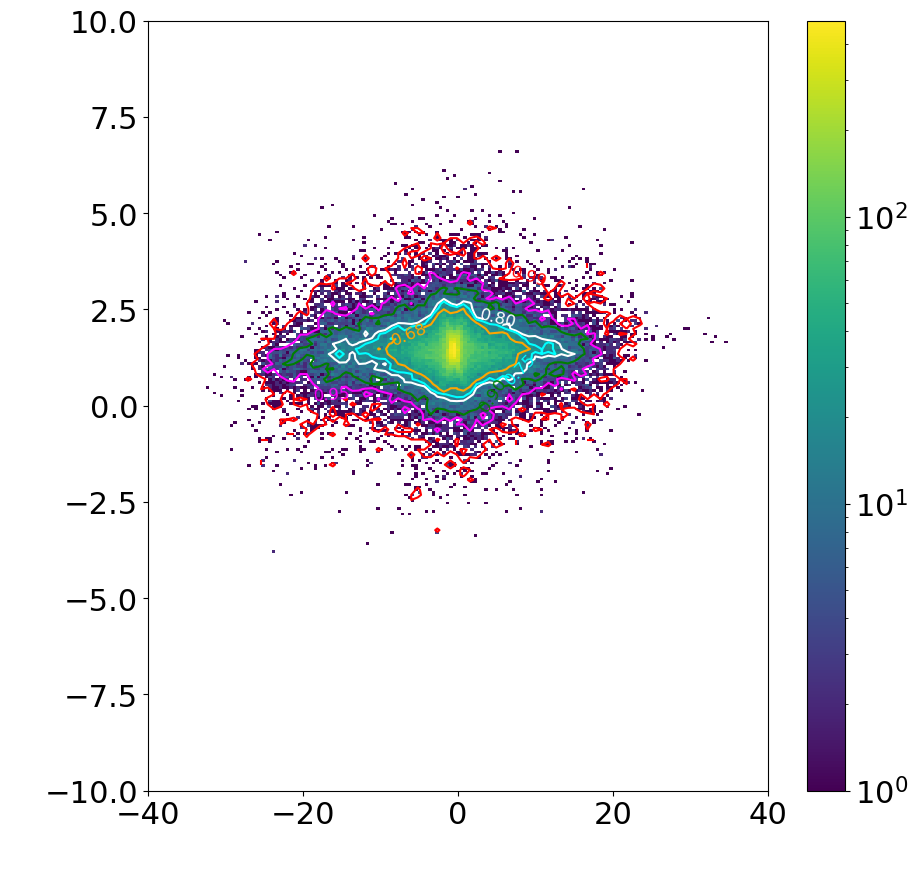

In [27]:
# Rotated M31 Disk - EDGE ON
# M31 Disk Density 
fig, ax= plt.subplots(figsize=(10, 10))
plt.hist2d(rn[:,0], rn[:,2], bins = 150, norm = LogNorm(), cmap = 'viridis')
# plot the particle density for M31 , 2D histogram
# ADD HERE
density_contour(rn[:,0], rn[:,2], 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])

plt.colorbar()

# Add axis labels
plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)

#set axis limits
plt.ylim(-10,10)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Save to a file
plt.savefig('Lab7_EdgeOn_Density.png')

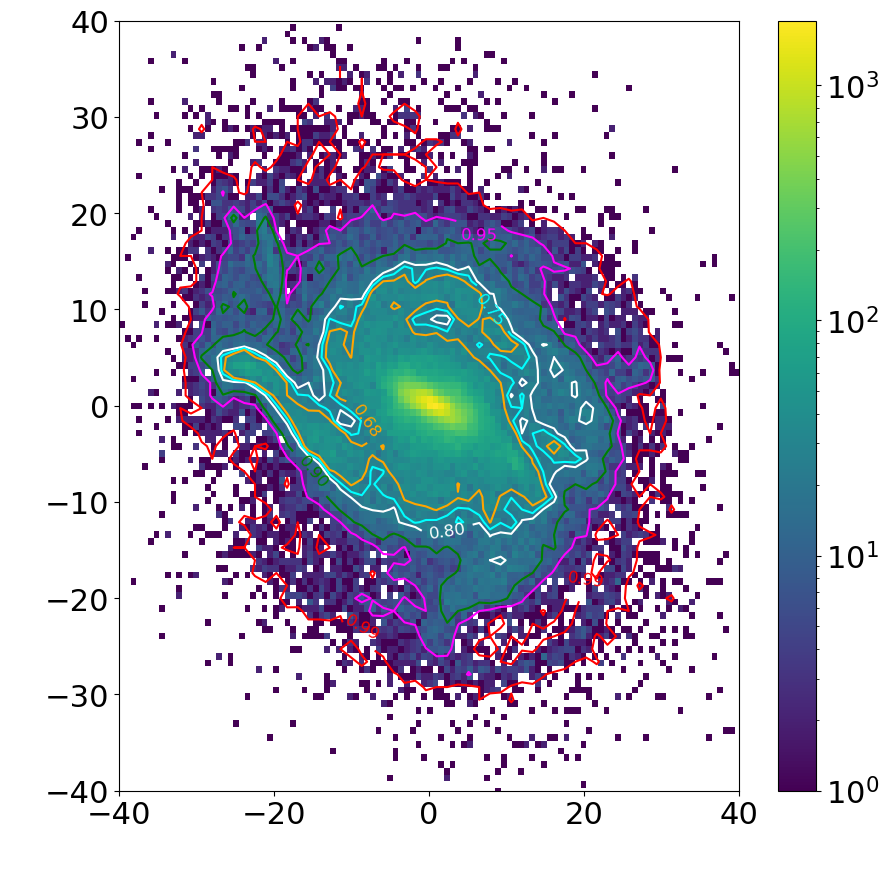

In [12]:
# Rotated M31 Disk - FACE ON

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(10, 10))
plt.hist2d(r[:,0], r[:,2], bins = 150, norm = LogNorm(), cmap = 'viridis')
# plot the particle density for M31 
# ADD HERE
density_contour(r[:,0], r[:,2], 80, 80, ax=ax, colors=['red', 'magenta', 'green','white','cyan', 'orange'])

plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# ADD HERE

# Add axis labels
plt.xlabel('  ', fontsize=22)
plt.ylabel('  ', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Save to a file 
plt.savefig('Lab7_FaceOn_Density.png')

# Part C

a) Create a scatter plot of the edge on disk particles, weighted by velocity.

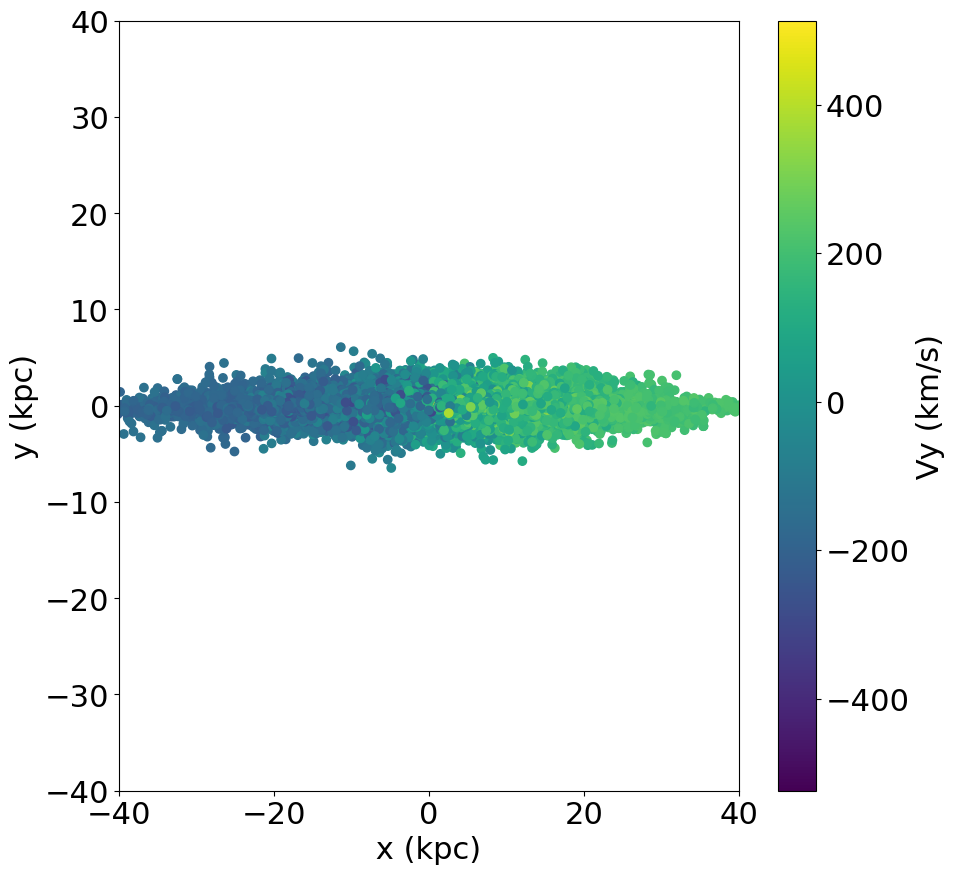

In [13]:
# Plot velocity weighted EDGE ON DISK

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot position of disk particles color coded by velocity along the 3rd axis
# plt.scatter(pos1, pos2, c=vel1)
# ADD HERE 

plt.scatter(rn[:,0],rn[:,2], c=vn[:,1])
#colorbar
cbar = plt.colorbar()
cbar.set_label(' Vy (km/s) ', size=22)

# Add axis labels
plt.xlabel(' x (kpc) ', fontsize=22)
plt.ylabel(' y (kpc) ', fontsize=22)


# calculate the 2D density of the data given
#counts,xbins,ybins=np.histogram2d(xD[index],yD[index],bins=100,normed=LogNorm())


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

# Save file
plt.savefig('Lab7_EdgeOn_Vel.png')

b) Create a phase diagram for the edge on disk (Position vs. Velocity) using a 2D Histogram.

c) Use the MassProfile Code to overplot the expected circular velocity from the mass profile. 

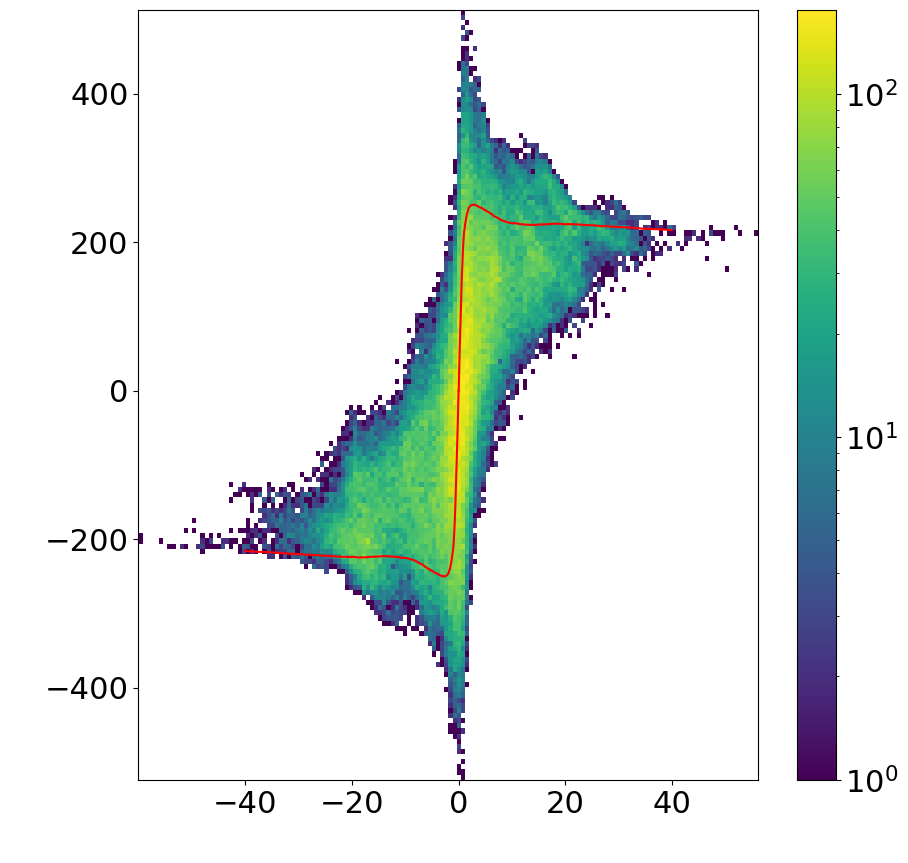

In [14]:
# Make a phase diagram
# MW Disk Velocity Field edge on.

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rn[:,0], vn[:,1], bins=150, norm = LogNorm())
plt.colorbar()

# Overplot Circular Velocity from the MassProfile Code
# ADD HERE

M31 = MassProfile("M31", 0)
R = np.arange(0.01, 40, 0.1)
VCirc = M31.circularVelocityTotal(R)
plt.plot(R, VCirc, color = 'red')
plt.plot(-R, -VCirc, color = 'red')
# Add axis labels
plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save file
plt.savefig('Lab7_PhaseDiagram.png')